<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT19/blob/bozzato/Lab-7/bozzato_lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 7: Optimization and learning**
**Bozzato Federico**

#Abstract

Short summary of the lab report. State the objectives, methods used, main results and conlusions. 

#About the code

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [1]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2019 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

#Set up environment

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [0]:
# Load neccessary modules.
from google.colab import files

import time

import numpy as np
from numpy import linalg as la

from matplotlib import pyplot as plt

#Introduction

Give a short description of the problem investigated in the report, and provide some background information so that the reader can understand the context. 

Briefly describe what method you have chosen to solve the problem, and justify why you selected that method. 

Here you can express mathematics through Latex syntax, and use hyperlinks for references.

[Hyperlink to DD2363 course website.](https://kth.instructure.com/courses/7500)

$
{\displaystyle \frac{\partial u}{\partial t}} + u\cdot \nabla u +\nabla p = f, \quad \nabla \cdot u=0$



#Useful tools

In [0]:
def gradient(fun, point, h= 0.01):      
  if not isinstance(point, np.ndarray):
    point= np.array(point)
    
  if point.shape == () or point.shape[0] == 1:
    n= 1
    
    return (fun(point+h) - fun(point-h)) / (2*h)
  
  else:
    n= point.shape[0]
    
    g= np.zeros((n,1))

    for i in range(n):
      p1= [x for x in point]
      p2= [x for x in point]
      
      p1[i]= p1[i] + h
      p2[i]= p2[i] - h

      g[i]= (fun(p1) - fun(p2)) / (2*h)

    return np.around(g, decimals=int(-np.log10(h))).flatten()
  
  
################################################################################
  
  
def hessian(fun, point, h= 0.01):
  if not isinstance(point, np.ndarray):
    point= np.array(point)
    
  if point.shape == () or point.shape[0] == 1:
    return (fun(point+2*h) - 2*fun(point) + fun(point-2*h))/ (4*h**2)
  else:
    n= point.shape[0]
    
    hess= np.zeros((n,n))
    for i in range(n):
      p1= [x for x in point]
      p2= [x for x in point]

      p1[i]= p1[i] + h
      p2[i]= p2[i] - h

      hess[i,:]= (gradient(fun, p1, h) - gradient(fun, p2, h)) / (2*h)
      
    return hess



#Methods

Describe the methods you used to solve the problem. This may be a combination of text, mathematical formulas (Latex), algorithms (code), data and output.  

##Mandatory assignment

###1. Gradient descent method in $R^n$

In [0]:
def minFinding(fun, x0, n_max= 1e6,  tol= 1e-5):

  if not isinstance(x0, np.ndarray):
    x0= np.array(x0)
     
  k= 0
  x= x0
  step= gradient(fun,x)
  x_previous= np.zeros_like(x)
  residuals= []
  residuals.append(la.norm(step))
  
  while residuals[k] >= tol and k < n_max:
    grad= gradient(fun, x)
    grad_previous= gradient(fun, x_previous)
    
    if k == 0:
      alpha= np.inner(x,grad) / la.norm(grad)**2
    else:
      alpha= np.inner(x-x_previous, grad - grad_previous) / la.norm(grad - grad_previous)**2
      
    x_previous= x
    x= x - alpha * grad
    
    res= la.norm(gradient(fun,x))
    residuals.append(res)
    k+= 1
    
  x= np.around(x, int(abs(np.log10(tol))))
  
  print('Convergence after {} iterations'.format(k))
  return x, np.array(residuals)

##Extra assignment

###2. Newton's method in $R^n$

In [0]:
def newtonMinFinding(fun, x0, n_max= 1e6, tol= 1e-5):
  if not isinstance(x0, np.ndarray):
    x0= np.array(x0)
    
  k= 0
  x= x0
  step= gradient(fun, x)
  
  residuals= []
  residuals.append(la.norm(step))
  while residuals[k] >= tol and k < n_max:
    hess= hessian(fun, x)
    if hess.shape == () or hess.shape[0] == 1:
      dx= -step / hess
    else:
      dx= la.lstsq(hess, -step, rcond=None)[0]
    
    x= x + dx
    step= gradient(fun, x)
    residuals.append(la.norm(step))
    k+= 1
  
  x= np.around(x, int(abs(np.log10(tol))))
  
  print('Convergence after {} iterations'.format(k))
  return x, np.array(residuals)

###3. Augmented Lagrangian method in $R^n$

**Input**: objective function f(x), constraints g(x) = c

**Output**: stationary point x* such that || dL/dx(x*) || < TOL

**Test**: verify accuracy and convergence with respect to exact solution 

In [0]:
# http://www.cis.pku.edu.cn/faculty/vision/zlin/Publications/ALM-v5.pdf

def augLagrangianMinimization(f, g, x0, tol= 1e-5):
  
  def augmentedLagrangian(f, g, gamma, n, m):
    
    lagr= lambda var: f(var[0:n]) - np.inner(var[n:n+m],g(var[0:n])) + gamma/2*la.norm(g(var[0:n]))**2
    
    return lagr

  
  if not isinstance(x0, np.ndarray):
    x0= np.array(x0)
  
  if x0.shape == () or x0.shape[0] == 1:
    n= 1
  else:
    n= x0.shape[0]
    
  tmp= g(x0)
  if tmp.shape == () or tmp.shape[0] == 1:               # m is the dimension of
    m= 1                                                 # lambda vector
  else:
    m= tmp.shape[0]
  
  x= np.zeros((n+m,))
  x[0:n]= x0
  
  gamma= 1.1                                           # regularisation parameter
                                                       # at 1st step
  lagr= augmentedLagrangian(f, g, gamma, n, m)
  k= 0
  step= gradient(lagr, x)
  
  residuals= []  
  residuals.append(la.norm(g(x[0:n])))
  while residuals[k] >= tol and k < 1000000:
    
    hess= hessian(lagr, x)
    if hess.shape == () or hess.shape[0] == 1:
      dx= -step / hess
    else:
      dx= la.lstsq(hess, -step, rcond=None)[0]
    
    #print('Hessian= \n', hess)
    #print(type(x), ' and x.shape= ', x.shape)
    #print(type(dx), ' and dx.shape= ', dx.shape)
       
    x[0:n]= x[0:n] + dx[0:n]
    x[n:n+m]= x[n:n+m] + gamma*(g(x[0:n]))
    gamma= 1.2*gamma                                   # beta = 1.2                     
    
    lagr= augmentedLagrangian(f, g, gamma, n, m)
    
    step= gradient(lagr, x)
    residuals.append(la.norm(g(x[0:n])))
    k+= 1
  
  print('Convergence after {} iterations'.format(k))
  return x[0:n].flatten(), np.array(residuals)

#Results

In [0]:
def minimization(fun, x0, method, str_fun, n_max= 1e6, tol= 1e-5):
  if method == 'newton':
    minimizer= newtonMinFinding
  elif method == 'gradient descent':
    minimizer= minFinding
    
  start= time.time()
  x, res= minimizer(fun, x0, n_max, tol)
  end= time.time()
  
  print('Solution found in {}s'.format(np.around(end-start)))
  
  interval= np.arange(x-1, x+1, 0.001)
  
  plt.figure()
  plt.plot(interval, fun(interval))
  plt.plot(x, fun(x), 'ro')
  plt.title('METHOD: {} - argmin( {} )= {}'.format(method, str_fun, x))
  plt.show()
    
  plt.figure()
  plt.loglog([x for x in range(0,res.shape[0])], res, 'o-')
  plt.title('Residuals')
  plt.show()
  



##1. Gradient descent method in $R^n$



Convergence after 648941 iterations
Solution found in 19.0s


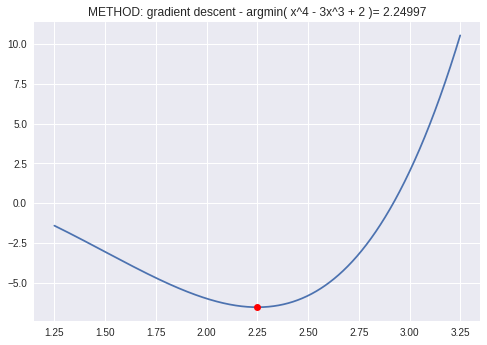

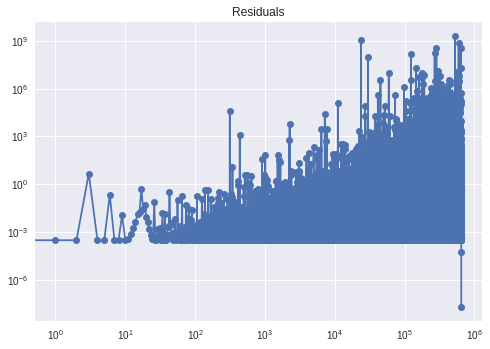

Convergence after 261 iterations
Solution found in 0.0s


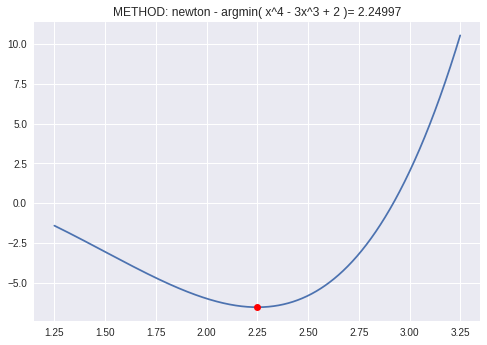

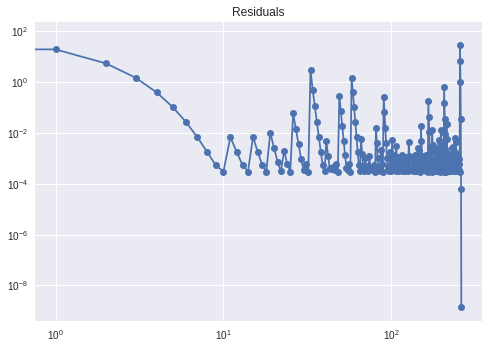

In [8]:
f= lambda x: x**4 - 3*x**3 + 2
x0= -2
minimization(f, x0, 'gradient descent', 'x^4 - 3x^3 + 2')
minimization(f, x0, 'newton', 'x^4 - 3x^3 + 2')

Convergence after 3 iterations
Solution found in 0.0s


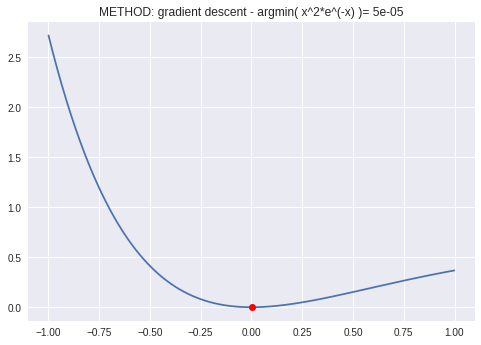

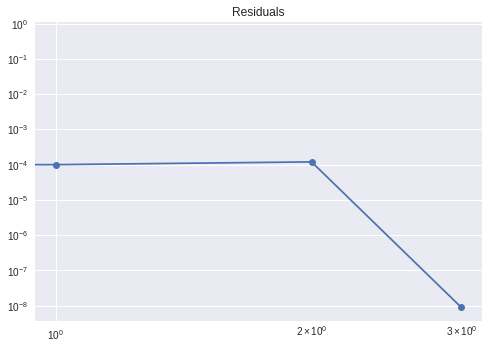

Convergence after 9 iterations
Solution found in 0.0s


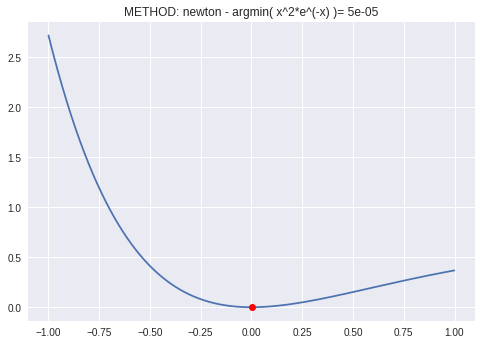

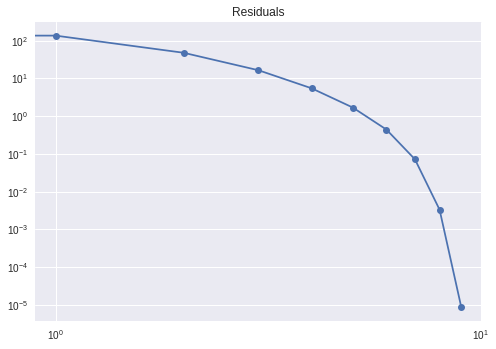

In [9]:
f= lambda x: x**2*np.e**(-x)
x0= 0.5
minimization(f, x0, 'gradient descent', 'x^2*e^(-x)')
minimization(f, x0, 'newton', 'x^2*e^(-x)')

Convergence after 3 iterations
[0.00158131 1.00013407]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


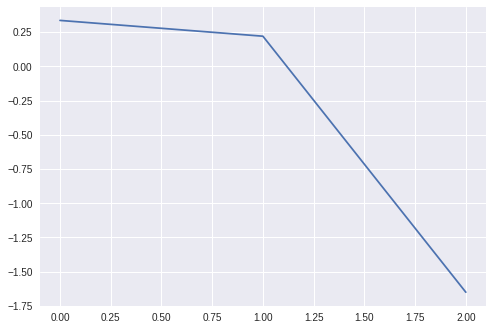

0.0
Convergence after 1 iterations
[0. 1.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


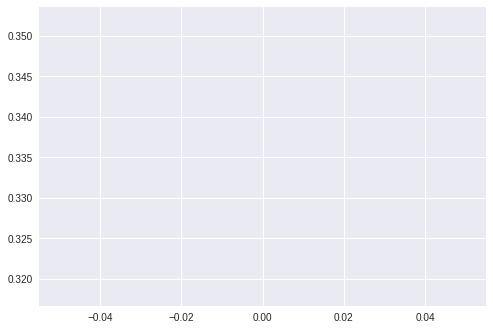

0.0


In [10]:
f= lambda x: x[0]**2 + (x[1]-1)**2 
x0= [0.6,0.1]
x1, res1= minFinding(f, x0, tol= 1e-8)

print(x1)
plt.figure()
plt.plot([x for x in range(0,res1.shape[0])], np.log10(res1))
plt.show()

print(res1[-1])

x2, res2= newtonMinFinding(f, x0, tol= 1e-8)

print(x2)
plt.figure()
plt.plot([x for x in range(0,res2.shape[0])], np.log10(res2))
plt.show()

print(res2[-1])

##2. Newton's method in $R^n$

##3. Augmented Lagrangian method in $R^n$

Convergence after 1 iterations
2.0906387732111398e-11
[1.22861721e-11 9.53659374e-12]
[1. 1.]


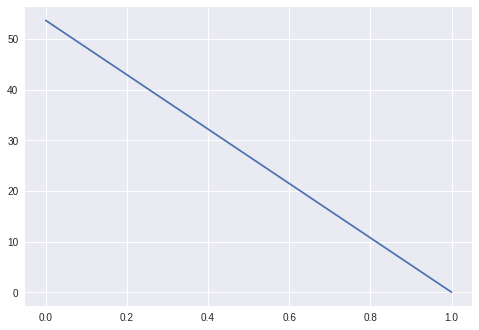

In [11]:
f= lambda x: np.array(x[0]**2 - x[1]**2)
g= lambda x: np.array( [x[0] + x[1] - 2, x[0] - 2*x[1] + 1 ] )

result, res= augLagrangianMinimization(f, g, [1,25])

print(f(result))
print(g(result))
print(result)

plt.figure()
plt.plot([x for x in range(0,res.shape[0])], res)
plt.show()

#Discussion

Summarize your results and your conclusions. Were the results expected or surprising. Do your results have implications outside the particular problem investigated in this report? 

#References

[1] from Wikipedia, *[Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)*